In [1]:
import sys
sys.path.append('../')
import numpy
import pandas
import seaborn
import matplotlib.pyplot as plt

from deepracer.tracks import TrackIO, Track

from deepracer.logs import \
    AnalysisUtils as au, \
    SimulationLogsIO as slio, \
    EvaluationUtils as eu, \
    PlottingUtils as pu,\
    NewRewardUtils as nr \

from reward import AWSReward, RewardFactory
import reward.awsreward as rewards
from utils.loader import load_logs, load_sample_complete_laps
from utils.transformer import df_to_params, calculate_iteration, new_names_df

tu = TrackIO(base_path='../tracks')
track = tu.load_track("reinvent_base")
fname = '../logs/training-simulation-logs-z6.log'

full_df = load_logs(fname)
calculate_iteration(full_df)

full_df['duration'] = full_df[['episode','numeric_timestamp']].groupby('episode').transform(lambda x: x - x.min())
df = full_df
import warnings
warnings.filterwarnings('ignore')

Loaded 71 waypoints


In [2]:
df.head()

,episode,step,x-coordinate,y-coordinate,heading,steering_angle,speed,action_taken,reward,job_completed,all_wheels_on_track,progress,closest_waypoint_index,track_length,time,status,numeric_timestamp,iteration,duration
0,39,370,1.9559,0.8551,-32.2944,30.0,0.33,6,3.8447,False,True,99.3768,68,17.67,2020-06-05 17:23:38,in_progress,1.591378e+09,2,24.794722
1,39,371,2.0039,0.8254,-32.1926,30.0,0.33,6,4.0505,False,True,99.6810,68,17.67,2020-06-05 17:23:38,in_progress,1.591378e+09,2,24.863124
2,39,372,2.0528,0.7994,-30.5910,30.0,0.67,7,4.5231,False,True,99.9854,68,17.67,2020-06-05 17:23:38,in_progress,1.591378e+09,2,24.931340
3,39,373,2.0931,0.7816,-28.6921,0.0,1.00,5,4.9682,True,True,100.0000,68,17.67,2020-06-05 17:23:38,lap_complete,1.591378e+09,2,25.001976
4,39,355,1.4253,1.1606,-43.3933,0.0,0.67,4,3.6143,False,True,94.9070,62,17.67,2020-06-05 17:23:37,in_progress,1.591378e+09,2,23.800718


In [15]:
def get_info_by_episode(df,episode):
    cols = ['x-coordinate','y-coordinate','speed','action_taken','steerin','numeric_timestamp','step']
    return df.loc[df.episode == episode, :].sort_values('step')

def calculate_instantaneous_velocity(t,x,y):
    import scipy.linalg as la
    dx, dy, dt = numpy.diff([x,y,t],prepend=0)  
    v = la.norm([dx,dy],axis=0) / dt 
    return v

def plot_velocity_and_speed_action(ep,v):
    speed = ep.speed.values
    step = ep.step.values
    actions = ep.action_taken.values
    plt.figure(figsize=(9,6))
    plt.scatter(step,v,alpha=0.5,s=2)
    plt.plot(step,v,alpha=0.5)
    plt.scatter(step,speed,s=10,c=actions,cmap='Paired')
    plt.plot(step,speed,alpha=0.2,linestyle='--')
    plt.colorbar()
    plt.xlabel('Step')
    plt.ylabel('Instantaneous velocity (continuos) / Speed[Action] (--)')
      
def plot_on_track(track,x,y,value,cmap='hot',title=''):
    fig, ax = plt.subplots(figsize=(9,6))
    ax.set_aspect('equal')
    pu.print_border(ax,track)
    plt.scatter(x,y,c=value,cmap=cmap)
    plt.colorbar(ax=ax,orientation='horizontal')
    plt.title(title)
    
def plot_velocity_on_track(track,x,y,ep):
    v = ep.velocity.values
    plot_on_track(track,x,y,v,cmap='hot',title='Instant velocity')
    
def plot_speed_on_track(track,x,y,ep):
    speed = ep.speed.values
    plot_on_track(track,x,y,speed,cmap='Paired',title='Speed Action')
    
def plot_action_on_track(track,df,ep):
    ep = get_info_by_episode(df,episode)
    x,y = ep[['x-coordinate','y-coordinate']].values.T
    action = ep.action_taken.values
    steps = ep.step.values
    plot_on_track(track,x,y,action,cmap='Paired',title='Action')
    plt.figure()
    plt.scatter(steps,action,c=action,cmap='Paired')
    
def add_velocity(ep):
    x,y,t = ep[['x-coordinate','y-coordinate','numeric_timestamp']].values.T
    v = calculate_instantaneous_velocity(t,x,y)
    ep['velocity'] = v    
    return t,x,y,v
    
def plot_velocity_analysis(df,episode):
    ep = get_info_by_episode(df,episode)
    t,x,y,v = add_velocity(ep)

    plot_velocity_and_speed_action(ep,v)
    plot_velocity_on_track(track,x,y,ep)
    plot_speed_on_track(track,x,y,ep)


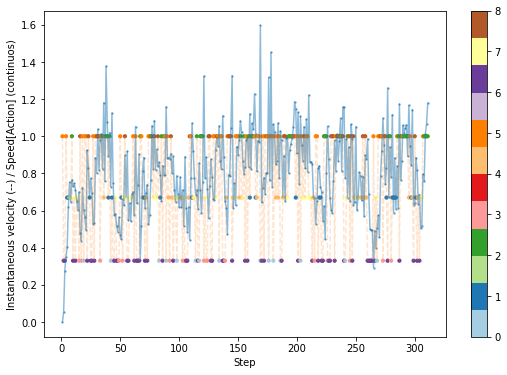

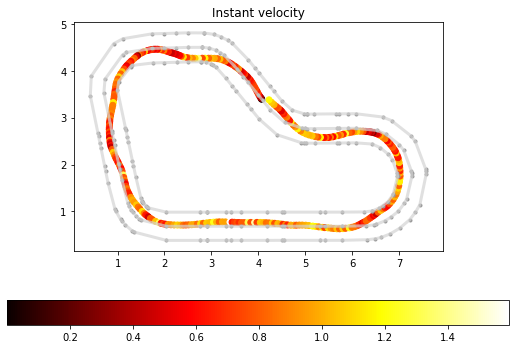

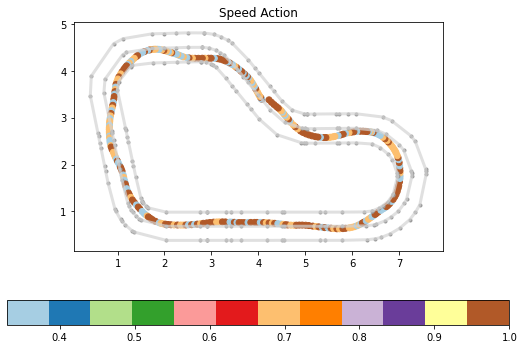

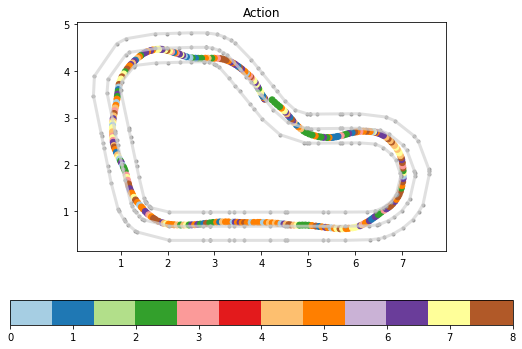

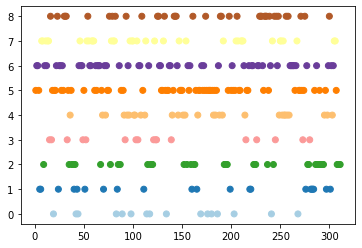

In [16]:
episode = 30
plot_velocity_analysis(df,episode)   
plot_action_on_track(track,df,episode)

In [22]:
import ipywidgets as widgets


tab_contents = ['P0', 'P1', 'P2', 'P3', 'P4']
children = [widgets.Text(description=name) for name in tab_contents]
tab = widgets.Tab()
tab.children = children
tab.titles = [str(i) for i in range(len(children))]
tab

